In [ ]:
import numpy as np
from f_util_preprocess import *


In [ ]:
def get_idx_of_end_of_blocks_across_sessions(data, hparams):
    """output: 
            list of arrays, each array shows index of last trial of blocks across hparams['sessions'] - size (num of sessions , corresponding_num_of_blocks_in_the_sess +1)
            for each session, it starts with 0 ands with the length of session - size(1,num_of_blocks_in_the_sess +1) """
    idx_end_of_blocks_in_sessions = []
    for sess in hparams['sessions']:
        p_rew_left = data[sess]['p_reward'][1,:]
        b = np.diff(p_rew_left)
        c = np.append((np.asarray(np.where(b != 0)))[0,:] , len(p_rew_left)-1)
        c = np.insert(c, 0, 0, axis=0)
        idx_end_of_blocks_in_sessions.append(c)
        
    return idx_end_of_blocks_in_sessions

In [ ]:
def get_trial_idx_at_the_begining_of_blockes_longer_than_threshold(idx_of_end_of_block, threshold):
    """
    input:  1D numpy array - size(1, num_of_blocks_in_the_sess +1)
    output: 1D numpy array - size(1, num blocks in that sess with length larger than threshold)
            trial index at the begining of blocks which are longer than threashold 
                """
    len_of_blocks  = np.diff(idx_of_end_of_block)
    idx =np.where(len_of_blocks>threshold)
    idx_of_end_of_blocks_longer_than_threshold = idx_of_end_of_block[idx]
    return idx_of_end_of_blocks_longer_than_threshold

In [ ]:
def get_block_idx_longer_than_threshold(idx_end_of_block, threshold):
    """input: 1D numpy array - size(1, num_of_blocks_in_the_sess +1)
        output: 1D numpy array - size(1, num blocks in that sess with length larger than threshold)"""
    len_of_block  = np.diff(idx_end_of_block)
    selected_blocks = np.asarray(np.where(len_of_block > threshold))
    return selected_blocks

In [ ]:
def get_list_blocks_and_trial_idx_longer_than_threshold(data, hparams, length_threshold):
    """
    output :    idx_of_end_of_blocks_longer_than_threshold_list  

                blocks_longer_than_threshold_list
                    list of arrays - size[num_sess,1]
                    each array : numpy array of size[1, num_qualifid_blocks]  - index of blocks featured by length longer than ""length_threshold" 
    """
    idx_of_end_of_blocks_across_sessions = get_idx_of_end_of_blocks_across_sessions(data, hparams)
    blocks_longer_than_threshold_list = []
    idx_of_end_of_blocks_longer_than_threshold_list =[]

    for sess_idx, sess in enumerate(hparams['sessions']):
        blockes_longer_than_threshold = np.array([]).reshape(1,-1)

        idx_of_end_of_blocks =  idx_of_end_of_blocks_across_sessions[sess_idx]
        idx_of_end_of_blocks_longer_than_threshold = get_trial_idx_at_the_begining_of_blockes_longer_than_threshold(idx_of_end_of_blocks, length_threshold)        
        idx_of_end_of_blocks_longer_than_threshold_list.append(idx_of_end_of_blocks_longer_than_threshold)


        blockes_longer_than_threshold = np.concatenate((blockes_longer_than_threshold, get_block_idx_longer_than_threshold(idx_of_end_of_blocks, length_threshold)) , axis = 1)
        blocks_longer_than_threshold_list.append(blockes_longer_than_threshold)

    return  idx_of_end_of_blocks_longer_than_threshold_list, blocks_longer_than_threshold_list


In [ ]:
length_threshold=3
idx_of_end_of_blocks_list,_ = get_list_blocks_and_trial_idx_longer_than_threshold(data, hparams, length_threshold=length_threshold)

first_l_choice_from_the_begining_of_blocks_stack = np.empty((0, length_threshold))


for sess_id,sess in enumerate(hparams['sessions']):
    data_choice_encoded = get_encoded_output_choice(data[sess]['choice_history'], hparams)

    for idx_of_end_of_block in idx_of_end_of_blocks_list[sess_id][:-1]:       
        first_l_choice_from_the_begining_of_block = data_choice_encoded[0,idx_of_end_of_block:idx_of_end_of_block+length_threshold].reshape(1,-1)
        first_l_choice_from_the_begining_of_blocks_stack = np.vstack((first_l_choice_from_the_begining_of_blocks_stack, first_l_choice_from_the_begining_of_block))

first_l_choice_from_the_begining_of_blocks_stack.shape

(451, 3)

In [ ]:
idx_of_end_of_blocks_list,_ = get_list_blocks_and_trial_idx_longer_than_threshold(data, hparams, length_threshold=length_threshold)

prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack = np.empty((0,))
post_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack = np.empty((0,))


for sess_id,sess in enumerate(hparams['sessions']):
    prior_block_prob_rew = data[sess]['p_reward'][1,:][idx_of_end_of_blocks_list[sess_id]][:-1]  # array of length (num_of qualified blockes) or array[]
    post_block_prob_rew = data[sess]['p_reward'][1,:][idx_of_end_of_blocks_list[sess_id]+1][:-1]      

    prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack = np.concatenate(\
        (prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack, prior_block_prob_rew))
    
    post_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack = np.concatenate(\
        (post_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack, post_block_prob_rew))

prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack = \
    prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack.reshape(-1,1)

post_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack = \
post_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack.reshape(-1,1)

prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack.shape

(451, 1)

(451, 3)


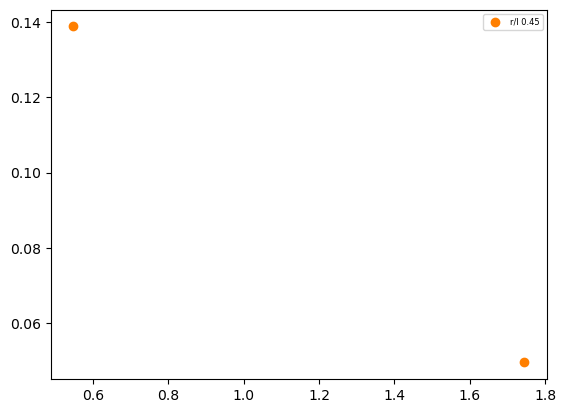

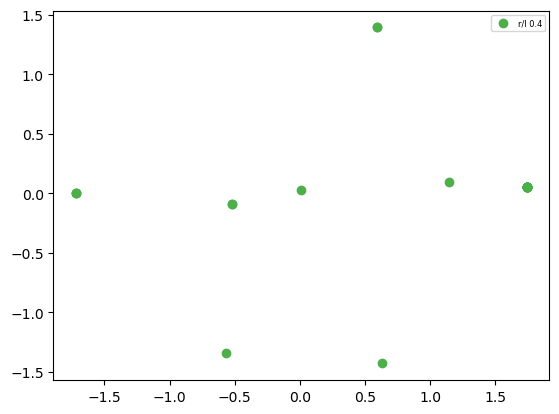

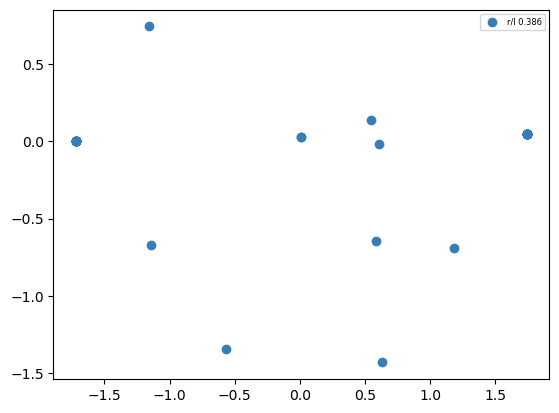

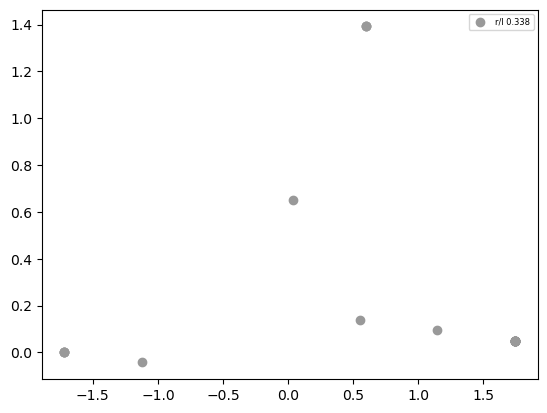

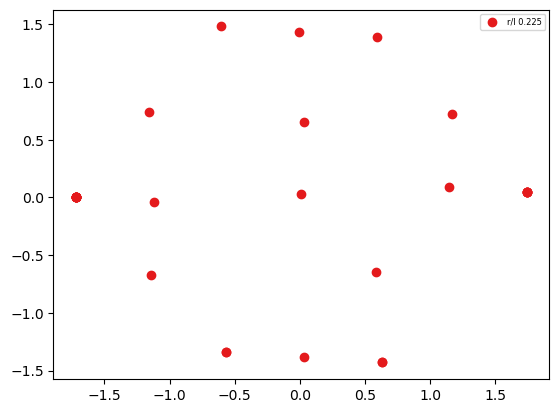

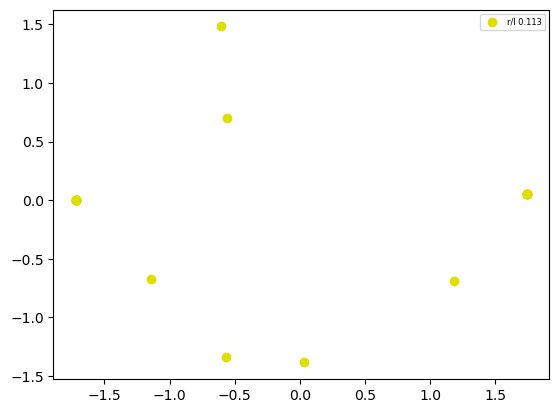

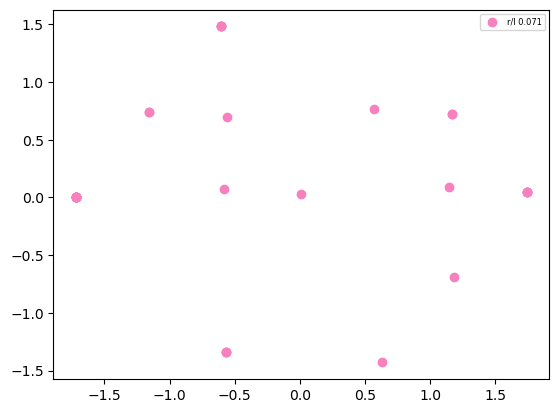

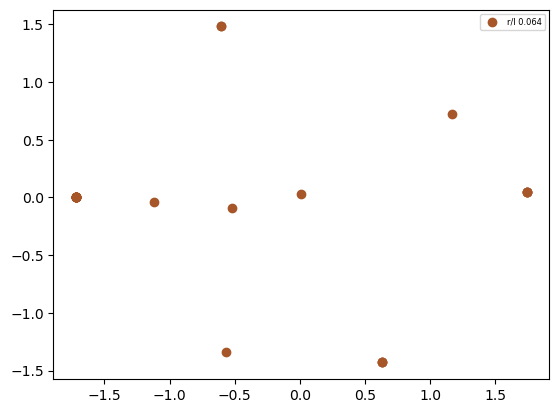

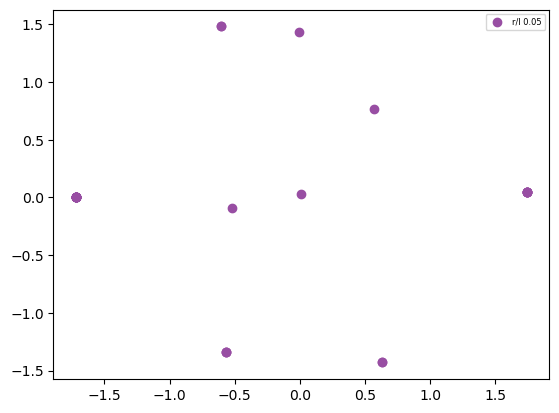

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


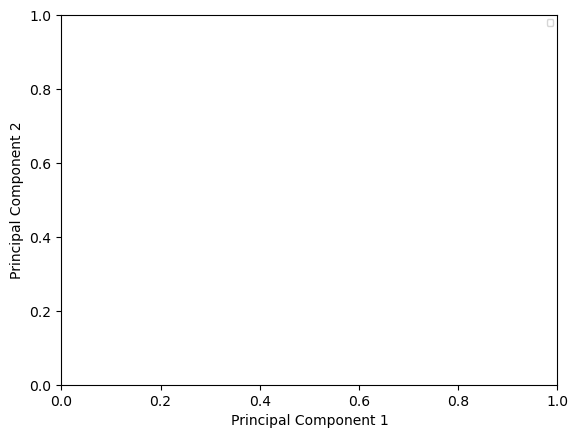

In [ ]:
"""choose between prior and post reward block"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

choice_serries_block_start = first_l_choice_from_the_begining_of_blocks_stack
print(choice_serries_block_start.shape)

# rew_serries_block_start = prior_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack
rew_serries_block_start = post_block_structure_prob_reward_for_first_l_choice_from_the_begining_of_blocks_longer_than_threshold_stack
# categories_rew_prob = np.unique(data[60]['p_reward'][1,:])
# segment_lebel = np.empty_like(rew_serries_block_start, dtype=int)

# for i,rew_prob in enumerate(categories_rew_prob):
#     segment_lebel[rew_serries_block_start == rew_prob] = i

n_components = 3
if choice_serries_block_start.shape[1] < n_components : n_components = choice_serries_block_start.shape[1]

# Create a PCA object and fit the data
pca = PCA()#(n_components= n_components)
pca.fit(choice_serries_block_start)
principal_components = pca.fit_transform(choice_serries_block_start)

# Get the loadings for the first two principal components
loadings = pca.components_[:2, :]
explained_variances = pca.explained_variance_ratio_

# Create a colormap that assigns a unique color to each point based on its position
fig, ax = plt.subplots()


# Create a scatter plot with different colors for each category
colors = hparams['colors']

# Create scatter plot with different colors for each category
for i,rew_prob in enumerate(hparams['category_rew_prob']):
    plt.scatter(principal_components[rew_serries_block_start[:,0] == rew_prob, 0], principal_components[rew_serries_block_start[:,0] == rew_prob, 1], \
                c=colors[i], alpha = 1, label='r/l '+str(hparams['category_rew_prob'][i]))
    
    plt.legend(fontsize=6)
    plt.show()


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(fontsize=6)
plt.show()

    

In [ ]:
hparams['category_rew_prob']

[0.45, 0.4, 0.386, 0.338, 0.225, 0.113, 0.071, 0.064, 0.05]

In [ ]:
color=colors[i]

In [ ]:
loadings

array([[ 0.55808822,  0.59811345,  0.57515027],
       [ 0.73976912, -0.04466357, -0.67137681]])

<BarContainer object of 3 artists>

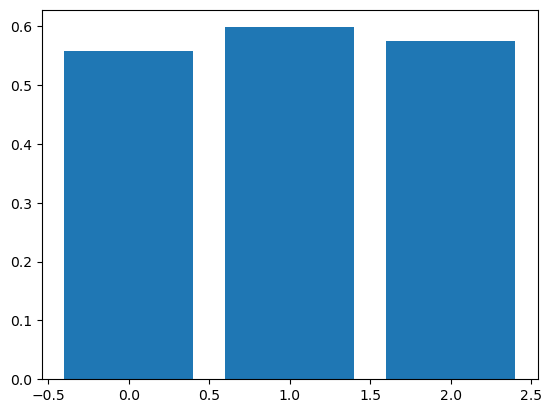

In [ ]:
plt.bar(range(loadings.shape[1]), loadings[0,:])

<BarContainer object of 3 artists>

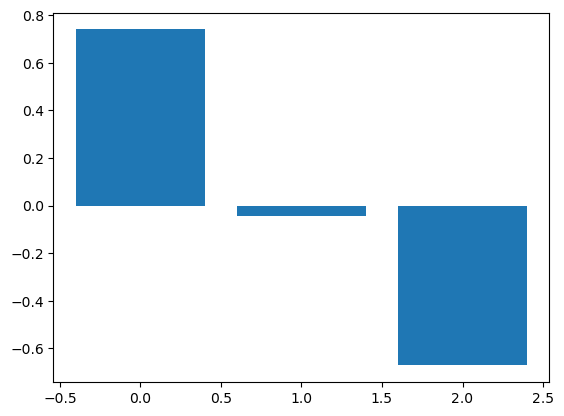

In [ ]:
plt.bar(range(loadings.shape[1]), loadings[1,:])

In [ ]:
explained_variances

array([0.76637845, 0.14714236, 0.08647919])

In [ ]:
def unique_sequences(arr, window_size):
    window_strides = arr.strides[0]
    windows = np.lib.stride_tricks.as_strided(arr, shape=(len(arr) - window_size + 1, window_size), strides=(window_strides, window_strides))

    unique_windows, counts = np.unique(windows, axis=0, return_counts=True)
    prob_occurence = counts/np.sum(counts)

    return unique_windows, counts, prob_occurence

In [ ]:
def get_sliding_windows_of_arr(arr, window_size):
    """
    input: 
            arr: size(1,num_trials) - can be array of a single session
            window_size = length of sequence
    """
    arr = arr.squeeze()
    num_seq = arr.shape[0] - window_size +1
    arr_2d = np.empty((num_seq, window_size), dtype=arr.dtype)
    for i in range(num_seq):
        start_idx = i 
        end_idx = start_idx + window_size
        arr_2d[i] = arr[start_idx:end_idx]
    return arr_2d

In [ ]:
idx_end_of_blocks_in_sessions = get_idx_of_end_of_blocks_across_sessions(data, hparams)

# length_threshold=5
if length_threshold < 10:
    offset_win_from_start = 10
else:
    offset_win_from_start = length_threshold

offset_win_to_end = 10
seq_win = length_threshold

choice_serries_block_middle = np.empty((0,seq_win))
rew_serries_block_middle = np.empty((0,))

for sess_id, sess  in enumerate(hparams['sessions']):
    data_choice_encoded = get_encoded_output_choice(data[sess]['choice_history'], hparams)
    rel_rew_prob_right = data[sess]['p_reward'][1,:]
    idx_end_of_blocks_in_sess = idx_end_of_blocks_in_sessions[sess_id]
    for i, idx_end_of_blocks in enumerate(idx_end_of_blocks_in_sess[:-1]):
        idx_win_ = range(idx_end_of_blocks_in_sess[i] + offset_win_from_start+1 , idx_end_of_blocks_in_sess[i+1]+1 - offset_win_to_end)
        arr_win = data_choice_encoded[0,idx_win_]
        if len(arr_win) > seq_win:
            seq_in_block = get_sliding_windows_of_arr(arr_win, seq_win)
            choice_serries_block_middle = np.vstack((choice_serries_block_middle, seq_in_block))
            # rew_prob_stack = np.vstack((rew_prob_stack, rel_rew_prob_right[idx_win_[0]: idx_win_[-1]-seq_win+1]))
            rew_serries_block_middle = np.append(rew_serries_block_middle, rel_rew_prob_right[idx_win_[0]: idx_win_[-1]-seq_win+2])

rew_serries_block_middle  = rew_serries_block_middle.reshape(-1,1)       
print(choice_serries_block_middle.shape)
print(rew_serries_block_middle.shape)



(15589, 3)
(15589, 1)


In [ ]:
def do_pca(datapoints, n_components=None):
    from sklearn.decomposition import PCA

    # n_components = 3
    if n_components is not None:
        if datapoints.shape[1] < n_components : n_components = datapoints.shape[1]
        pca = PCA(n_components= n_components)
    else:
        pca = PCA()#(n_components= n_components)
    pca.fit(datapoints)
    principal_components = pca.fit_transform(datapoints)
    loadings = pca.components_ #[:2, :]
    explained_variances = pca.explained_variance_ratio_

    return principal_components, loadings, explained_variances

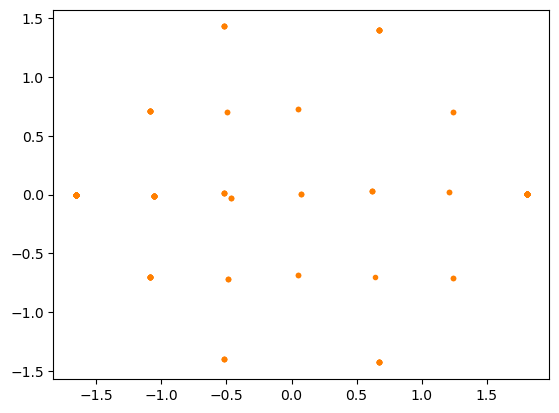

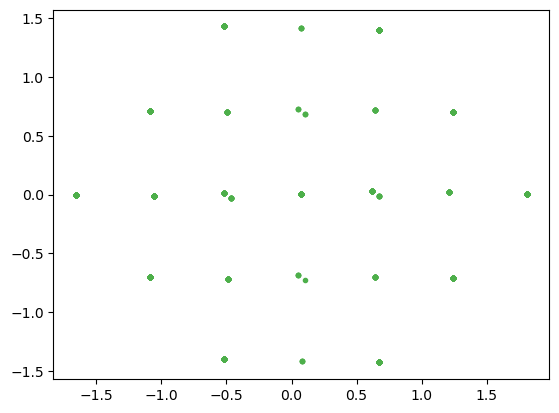

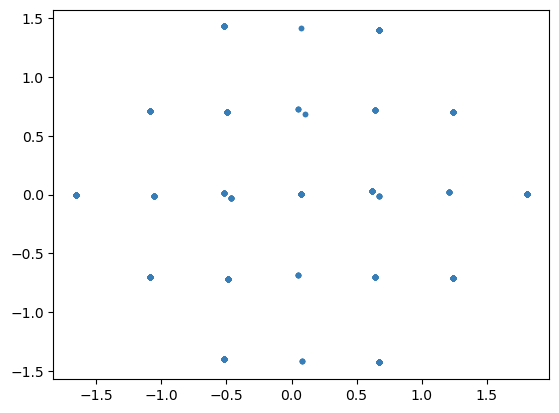

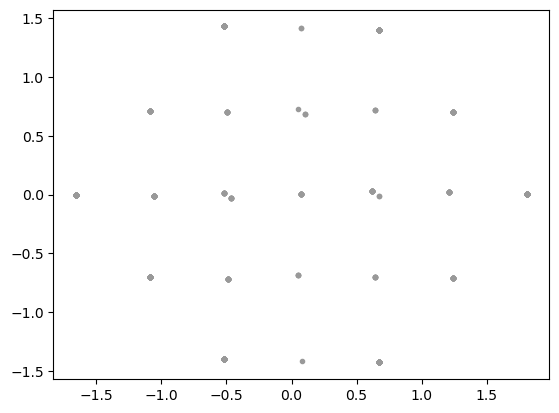

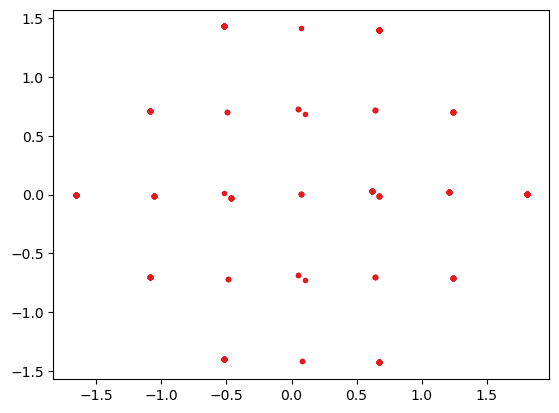

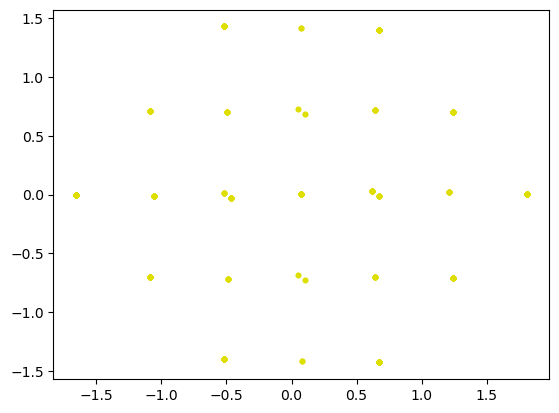

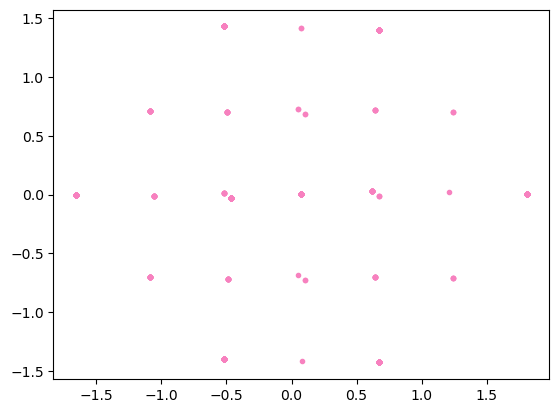

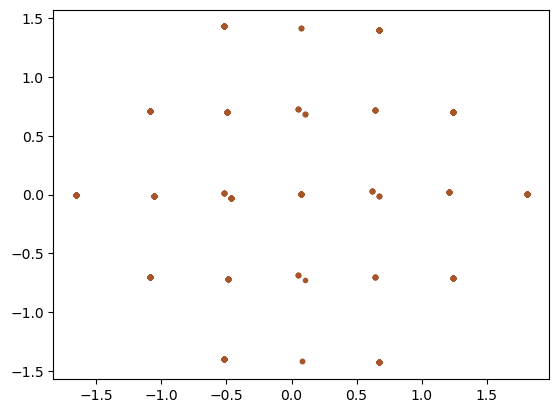

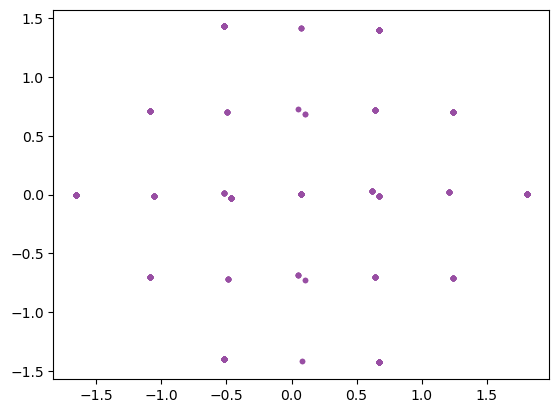

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


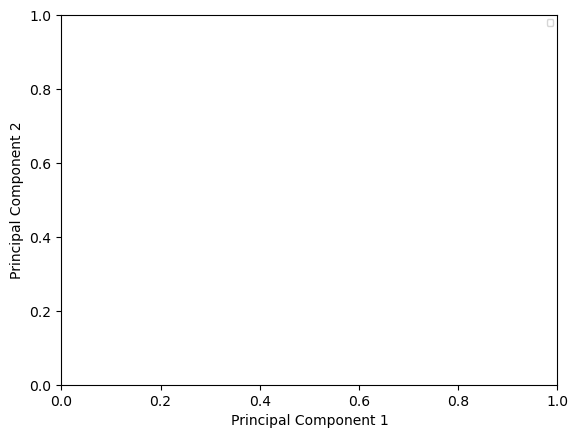

In [ ]:
from sklearn.decomposition import PCA

# n_components = 3
if choice_serries_block_middle.shape[1] < n_components : n_components = choice_serries_block_middle.shape[1]

# Create a PCA object and fit the data
pca = PCA()#(n_components= n_components)
pca.fit(choice_serries_block_middle)
principal_components = pca.fit_transform(choice_serries_block_middle)

# Get the loadings for the first two principal components
loadings = pca.components_[:2, :]
explained_variances = pca.explained_variance_ratio_

# Create a colormap that assigns a unique color to each point based on its position
fig, ax = plt.subplots()


# Create a scatter plot with different colors for each category
colors = hparams['colors']

# Create scatter plot with different colors for each category
for i,rew_prob in enumerate(hparams['category_rew_prob']):
    plt.scatter(principal_components[rew_serries_block_middle[:,0] == rew_prob, 0], principal_components[rew_serries_block_middle[:,0] == rew_prob, 1], \
                marker='.', c=colors[i], alpha = 1, label='r/l '+str(hparams['category_rew_prob'][i]))
    plt.show()


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(fontsize=6)
plt.show()

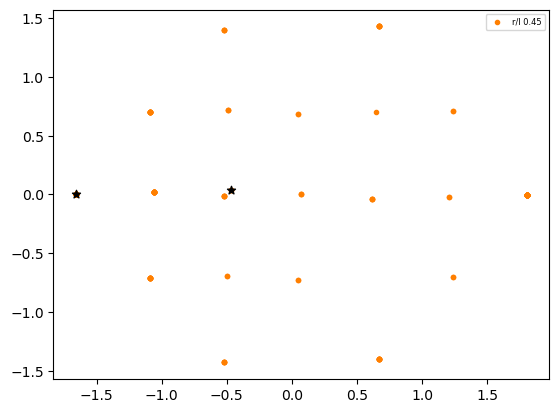

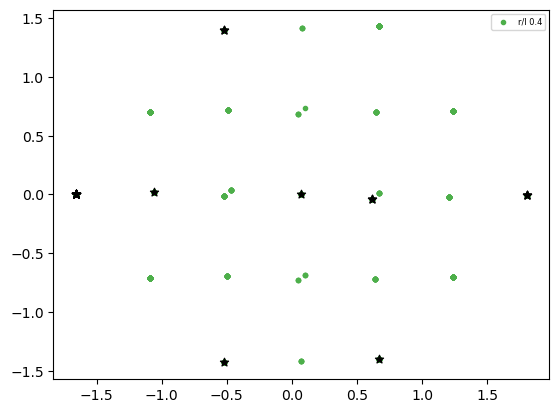

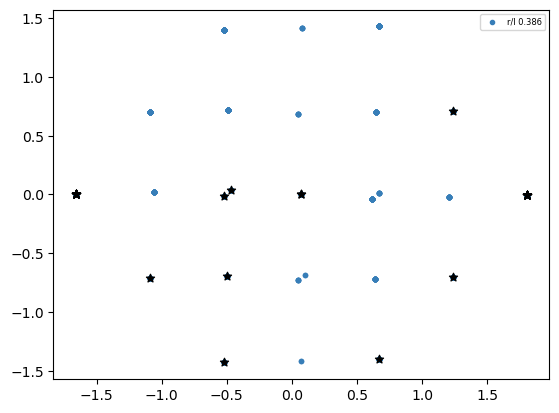

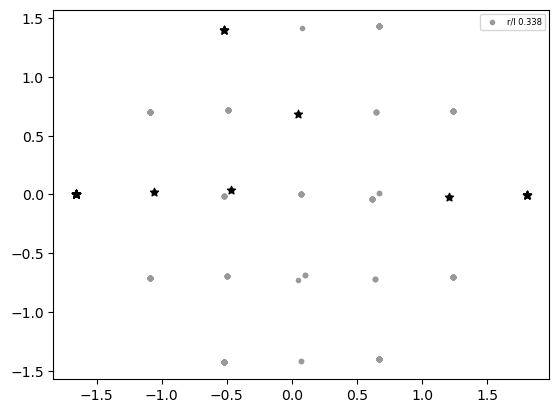

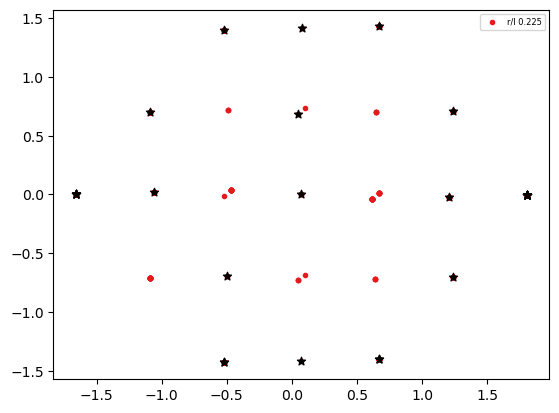

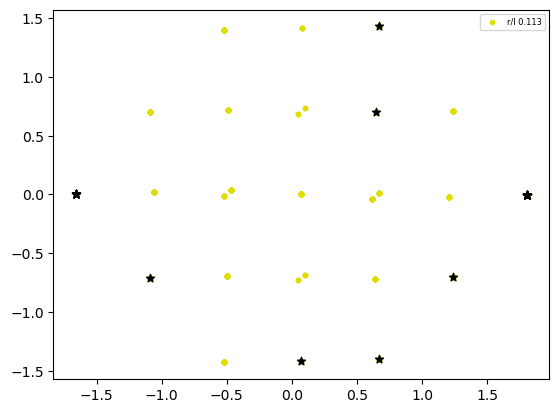

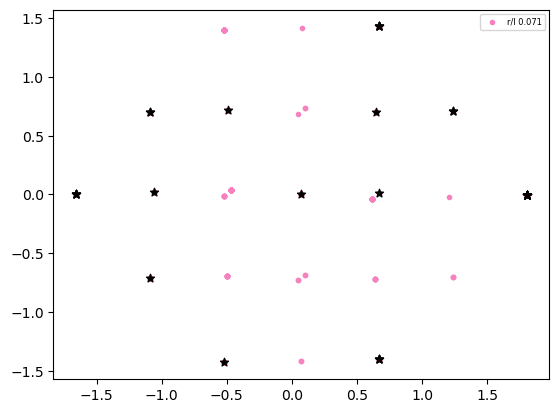

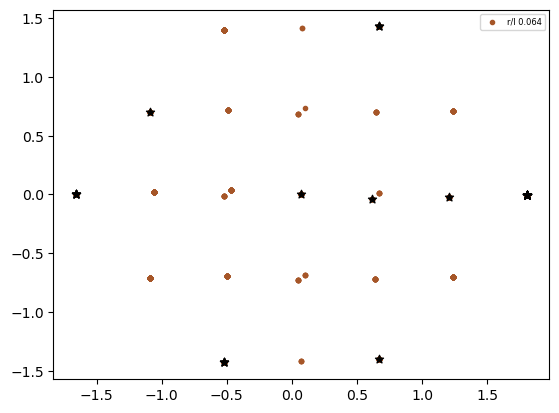

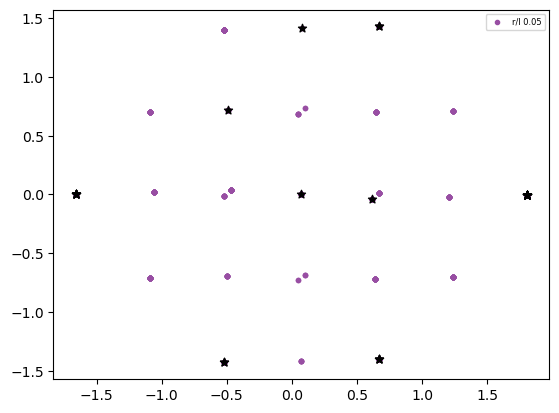

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


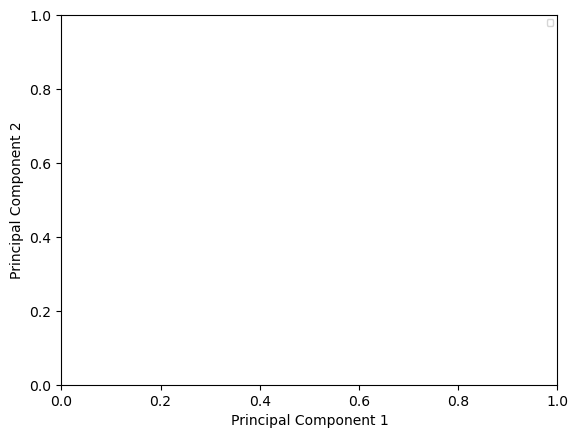

In [ ]:
tot_choice_serries = np.vstack((choice_serries_block_middle, choice_serries_block_start))
tot_rew_serries = np.vstack((rew_serries_block_middle, rew_serries_block_start))

idx_middle = range(choice_serries_block_middle.shape[0])
idx_start = range(choice_serries_block_middle.shape[0], tot_choice_serries.shape[0])

principal_components, loadings, explained_variances = do_pca(tot_choice_serries, n_components=None)

fig, ax = plt.subplots()

# # Create scatter plot with different colors for each category
for i,rew_prob in enumerate(hparams['category_rew_prob']):
    filtered_pcs_middle = principal_components[idx_middle][tot_rew_serries[idx_middle,0] == rew_prob]
    plt.scatter(filtered_pcs_middle[:,0],filtered_pcs_middle[:,1], marker='.', c=colors[i], alpha = 1, label='r/l '+str(hparams['category_rew_prob'][i]))
# for i,rew_prob in enumerate(hparams['category_rew_prob']):
    filtered_pcs_start = principal_components[idx_start][tot_rew_serries[idx_start,0] == rew_prob]
    plt.scatter(filtered_pcs_start[:,0],filtered_pcs_start[:,1], marker='*', c='k', alpha = 1)
    
    plt.legend(fontsize=6)
    plt.show()


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(fontsize=6)
plt.show()


In [ ]:
principal_components.shape

(16040, 3)

In [ ]:
choice_serries_block_start.shape


(451, 3)

In [ ]:
rew_serries_block_start.shape

(451, 1)

In [ ]:
hparams['category_rew_prob']

[0.45, 0.4, 0.386, 0.338, 0.225, 0.113, 0.071, 0.064, 0.05]

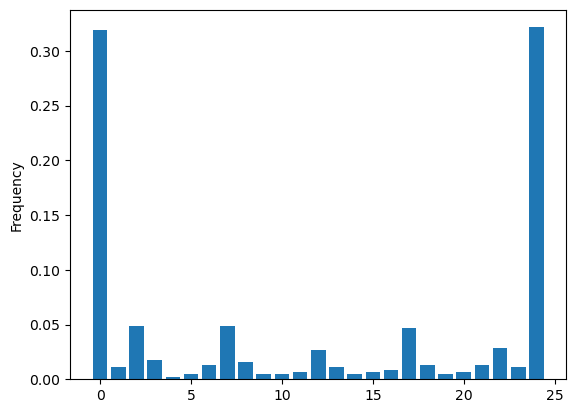

In [ ]:
choice_serries_block_start
unique_windows, counts = np.unique(choice_serries_block_start, axis=0, return_counts=True)
prob_occurence = counts/np.sum(counts)
plt.bar(range(len(unique_windows)), prob_occurence)
# plt.xticks(x_pos, sequences, rotation=90)
plt.ylabel('Frequency')
plt.show()

In [ ]:
unique_windows[prob_occurence>.05]

array([[0., 0., 0.],
       [2., 2., 2.]])

In [ ]:
unique_windows[(prob_occurence<.02) & (prob_occurence>.005)]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 2., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 2.],
       [1., 2., 1.],
       [1., 2., 2.],
       [2., 0., 2.],
       [2., 1., 1.],
       [2., 1., 2.],
       [2., 2., 1.]])

In [ ]:
choice_data_ = data[sess]['choice_history']
window_size = 10
choice_data_window = get_sliding_windows_of_choice_history(arr = choice_data_, window_size = window_size)
unique_windows, counts, prob_occurence = unique_sequences(choice_data_window, window_size)
plt.bar(range(len(unique_windows)), prob_occurence)
# plt.xticks(x_pos, sequences, rotation=90)
plt.ylabel('Frequency')
plt.show()

NameError: name 'get_sliding_windows_of_choice_history' is not defined

In [ ]:
unique_windows[prob_occurence>.05]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
unique_windows[(prob_occurence<.05) & (prob_occurence>.01)]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
unique_windows[(prob_occurence>.005) & (prob_occurence<.01)]

array([], shape=(0, 10), dtype=float64)

In [ ]:
unique_windows[(prob_occurence>.01) & (prob_occurence<.03)]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

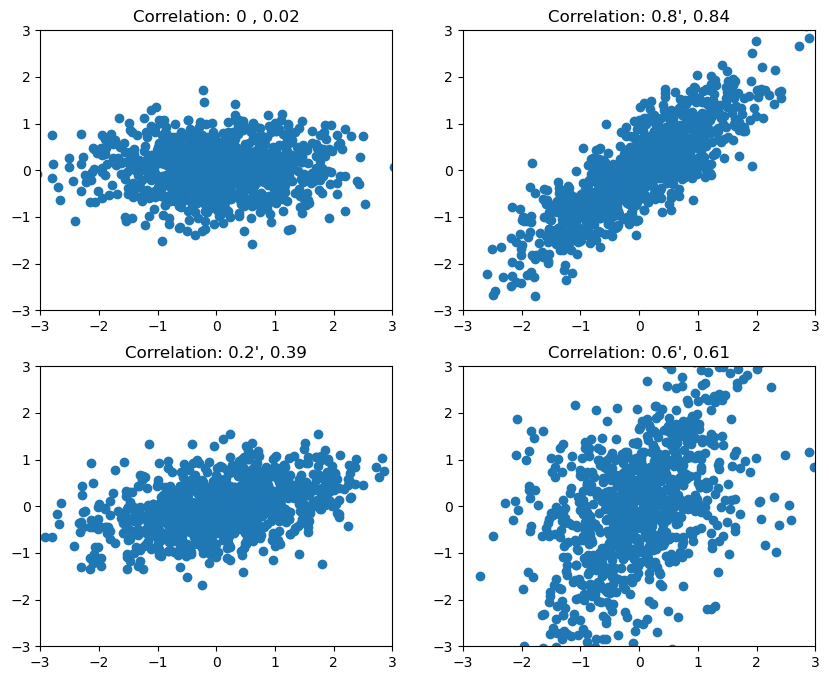

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate datasets with different correlation values
np.random.seed(1)
x1 = np.random.normal(0, 1, 1000)
y1 = np.random.normal(0, .5, 1000)
x2 = np.random.normal(0, 1, 1000)
y2 = .8 * x2 + np.random.normal(0, .5, 1000)
x3 = np.random.normal(0, 1, 1000)
y3 = 0.2 * x3 + np.random.normal(0, .5, 1000)
x4 = np.random.normal(0, 1, 1000)
y4 = np.random.normal(0, 1, 1000)
y4[:500] += 2 * x4[:500]


corr1 = np.corrcoef(x1, y1)[0, 1]
corr2 = np.corrcoef(x2, y2)[0, 1]
corr3 = np.corrcoef(x3, y3)[0, 1]
corr4 = np.corrcoef(x4, y4)[0, 1]

# Plot the datasets with different correlation values
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].scatter(x1, y1)
axs[0, 0].set_title(f"Correlation: 0 , {corr1:.2f}")
axs[0, 0].set_xlim([-3,3])
axs[0, 0].set_ylim([-3,3])
axs[0, 1].scatter(x2, y2)
axs[0, 1].set_title(f"Correlation: 0.8', {corr2:.2f}")
axs[0, 1].set_xlim([-3,3])
axs[0, 1].set_ylim([-3,3])
axs[1, 0].scatter(x3, y3)
axs[1, 0].set_title(f"Correlation: 0.2', {corr3:.2f}")
axs[1, 0].set_xlim([-3,3])
axs[1, 0].set_ylim([-3,3])
axs[1, 1].scatter(x4, y4)
axs[1, 1].set_title(f"Correlation: 0.6', {corr4:.2f}")
axs[1, 1].set_xlim([-3,3])
axs[1, 1].set_ylim([-3,3])
plt.show()


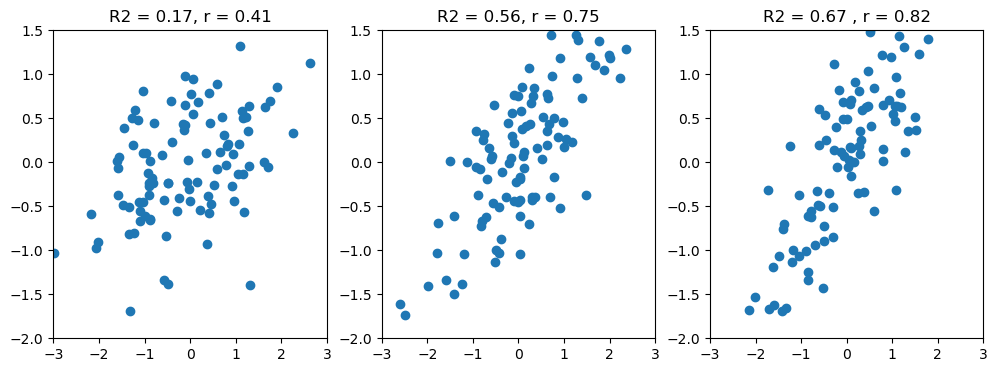

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate dataset 1 with low R2 value
x1 = np.random.normal(0, 1, 100)
y1 = 0.2 * x1 + np.random.normal(0, 0.5, 100)
corr1 = np.corrcoef(x1, y1)[0, 1]
r2_1 = corr1 ** 2

# Generate dataset 2 with medium R2 value
x2 = np.random.normal(0, 1, 100)
y2 = 0.6 * x2 + np.random.normal(0, 0.5, 100)
corr2 = np.corrcoef(x2, y2)[0, 1]
r2_2 = corr2 ** 2

# Generate dataset 3 with high R2 value
x3 = np.random.normal(0, 1, 100)
y3 = 0.8 * x3 + np.random.normal(0, 0.5, 100)
corr3 = np.corrcoef(x3, y3)[0, 1]
r2_3 = corr3 ** 2

# Plot the datasets
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(x1, y1)
ax[0].set_title(f"R2 = {r2_1:.2f}, r = {corr1:.2f}")
ax[0].set_xlim([-3,3])
ax[0].set_ylim([-2,1.5])
ax[1].scatter(x2, y2)
ax[1].set_title(f"R2 = {r2_2:.2f}, r = {corr2:.2f}")
ax[1].set_xlim([-3,3])
ax[1].set_ylim([-2,1.5])
ax[2].scatter(x3, y3)
ax[2].set_title(f"R2 = {r2_3:.2f} , r = {corr3:.2f}")
ax[2].set_xlim([-3,3])
ax[2].set_ylim([-2,1.5])
plt.show()
